### Importing Relevant Packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

### Loading and Transforming the Data

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')



### Removing Surplus Data

In [3]:
df_comp['market_value']=df_comp.spx

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

### White Noise

In [5]:
wn = np.random.normal(loc=df.market_value.mean(), scale=df.market_value.std(), size = len(df))

In [6]:
df['wn']=wn

<ipython-input-6-668c275da1fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wn']=wn


In [7]:
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1087.726454
std,292.559287,296.012942
min,438.920000,79.336769
25%,914.620000,886.591582
50%,1144.650000,1087.866320
75%,1316.280729,1287.847648
max,1570.252238,2023.637367


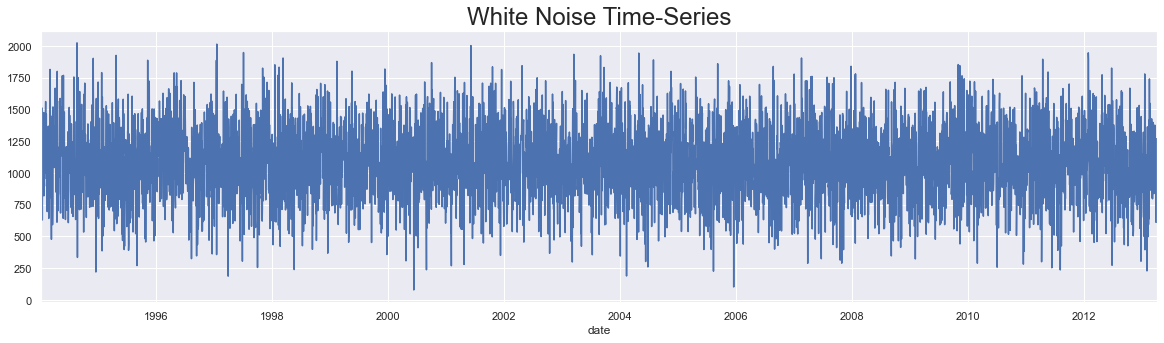

In [8]:
# use plot method to plot white noise data
df.wn.plot(figsize=(20,5))
plt.title("White Noise Time-Series", size=24)
plt.show()

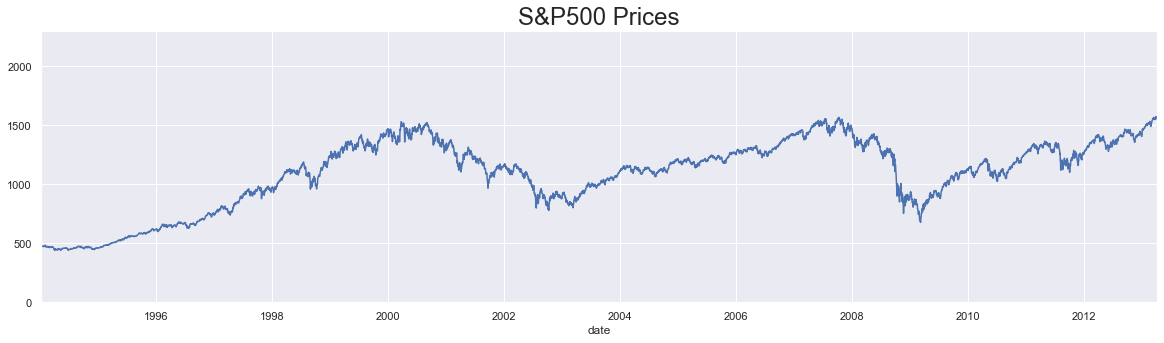

In [9]:
df.market_value.plot(figsize=(20,5))
plt.title("S&P500 Prices", size=24)
plt.ylim(0,2300) # to match range of y-axis in white noise data for comparability
plt.show()

### Random Walk

In [10]:
rw = pd.read_csv('RandWalk.csv')
rw.date =  pd.to_datetime(rw.date, dayfirst=True)
rw.set_index("date", inplace=True)
rw = rw.asfreq("b")

In [11]:
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [12]:
df['rw'] = rw.price

<ipython-input-12-ef067d009833>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rw'] = rw.price


In [13]:
df.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,1352.627807,1122.139662
1994-01-10,475.27,877.420046,1080.347860
1994-01-11,474.13,1513.255662,1082.095245
1994-01-12,474.17,1510.460049,1083.639265
1994-01-13,472.47,1037.605175,1067.146255


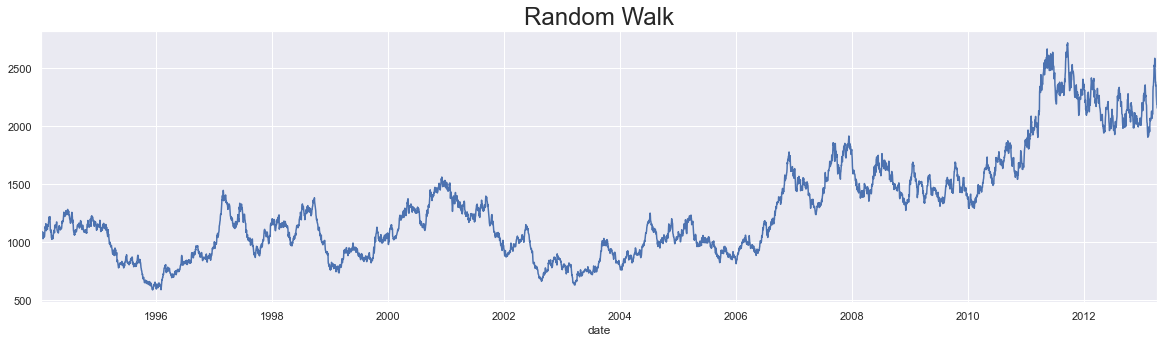

In [14]:
df.rw.plot(figsize=(20,5))
#df.market_value.plot()
plt.title("Random Walk", size=24)
plt.show()

### Stationarity

Perform the Dickey-Fuller Test

In [15]:
# Run the test for S&P data
sts.adfuller(df.market_value)

(-1.7369847452352427,
 0.4121645696770626,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

Our test-statistic value is -1.7369. It is is below the 5% critical value of -2.8621. The number of lags used in the regression when determining the t-statistic is 18. Finally, we have 5002 observations.

In [16]:
# Run the test for White Noise
sts.adfuller(df.wn)

(-70.71223593909791,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 70933.62855518833)

In [17]:
# Run the test for Random Walk
sts.adfuller(df.rw)

(-1.328607392768972,
 0.6159849181617384,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

### Seasonality

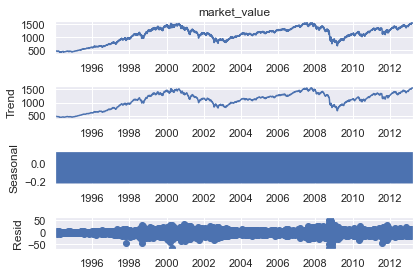

In [18]:
# Naive decomposition - additive
s_dec_additive = seasonal_decompose(df.market_value, model = "additive")
s_dec_additive.plot()
plt.show()

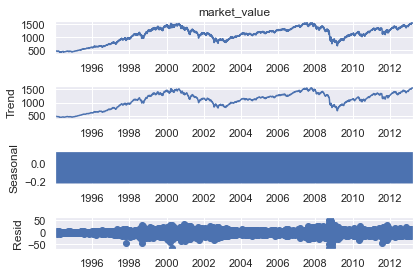

In [19]:
# Naive decomposition - multiplicative
s_dec_multiplicative = seasonal_decompose(df.market_value, model = "additive")
s_dec_multiplicative.plot()
plt.show()

No seasonaility in S&P prices.

### Autocorrelation Function (ACF)

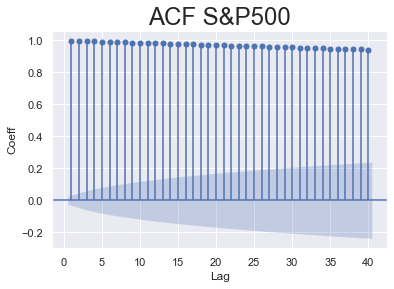

In [33]:
# Plot the autocorrelation function
sgt.plot_acf(df.market_value, lags=40, zero=False)
plt.title("ACF S&P500", size=24)
plt.xlabel("Lag")
plt.ylabel("Coeff")
plt.show()

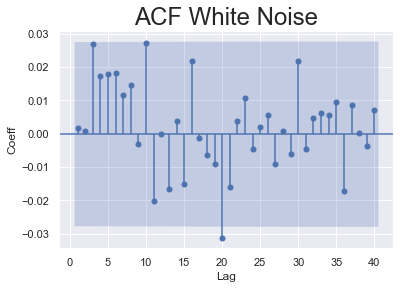

In [32]:
# Plot the autocorrelation function
sgt.plot_acf(df.wn, lags=40, zero=False)
plt.title("ACF White Noise", size=24)
plt.xlabel("Lag")
plt.ylabel("Coeff")
plt.show()

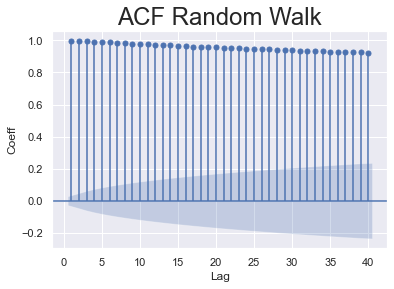

In [31]:
# Plot the autocorrelation function
sgt.plot_acf(df.rw, lags=40, zero=False)
plt.title("ACF Random Walk", size=24)
plt.xlabel("Lag")
plt.ylabel("Coeff")
plt.show()

### Partial Autocorrelation Function (PACF)

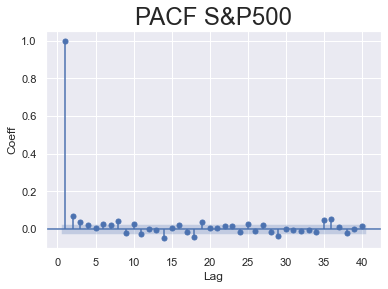

In [34]:
# Plot the partial autocorrelation function using OLS
sgt.plot_pacf(df.market_value, lags=40,zero=False, method=('ols'))
plt.title("PACF S&P500", size=24)
plt.xlabel("Lag")
plt.ylabel("Coeff")
plt.show()

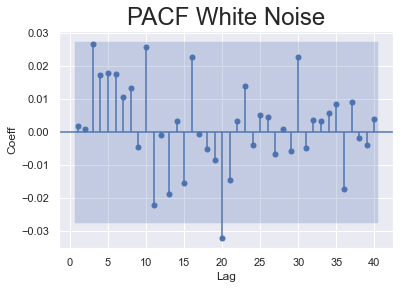

In [35]:
# Plot the partial autocorrelation function using OLS
sgt.plot_pacf(df.wn, lags=40,zero=False, method=('ols'))
plt.title("PACF White Noise", size=24)
plt.xlabel("Lag")
plt.ylabel("Coeff")
plt.show()

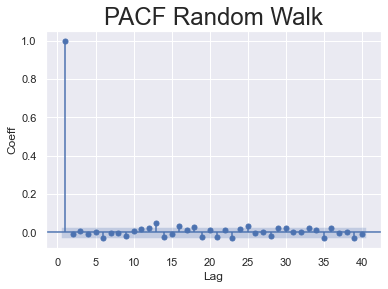

In [36]:
# Plot the partial autocorrelation function using OLS
sgt.plot_pacf(df.rw, lags=40,zero=False, method=('ols'))
plt.title("PACF Random Walk", size=24)
plt.xlabel("Lag")
plt.ylabel("Coeff")
plt.show()